In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

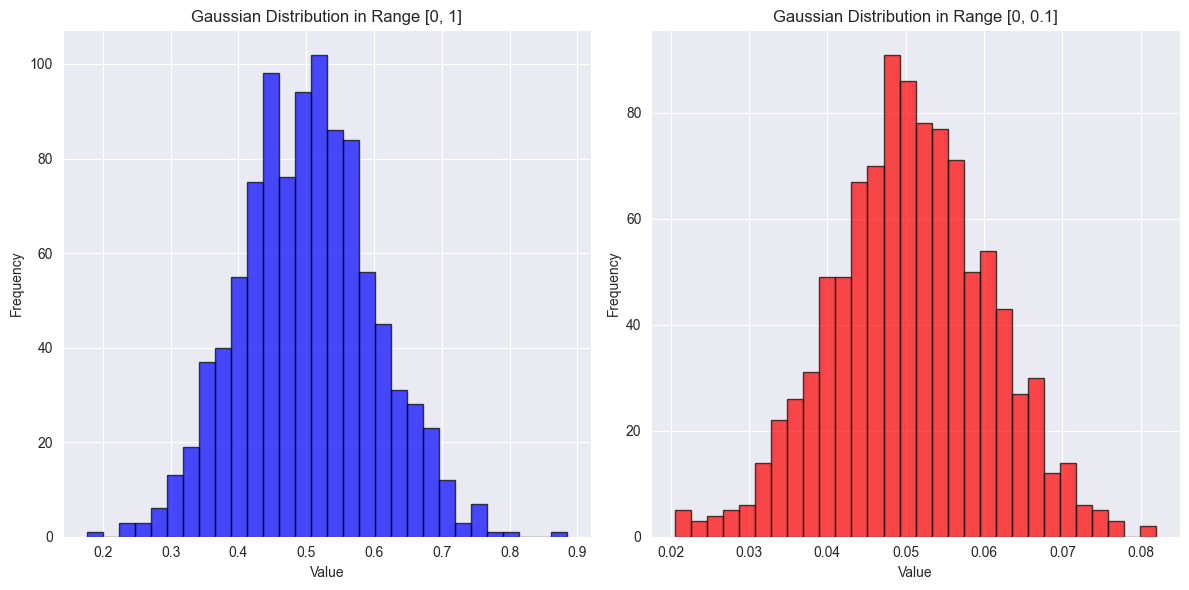

In [65]:
import numpy as np
import matplotlib.pyplot as plt

# 设置随机种子，保证结果可重复
np.random.seed(42)

# 第一个高斯分布的均值和标准差
mean1, std1 = 0.5, 0.1
# 生成1000个样本
data1 = np.random.normal(mean1, std1, 1000)

# 第二个高斯分布的均值和标准差
mean2, std2 = 0.05, 0.01
# 生成1000个样本
data2 = np.random.normal(mean2, std2, 1000)

# 限制数据值的范围，确保值落在[0,1]和[0, 0.1]区间内
# data1 = np.clip(data1, 0, 1)
# data2 = np.clip(data2, 0, 0.1)

# 可视化数据
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data1, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Gaussian Distribution in Range [0, 1]')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data2, bins=30, color='red', alpha=0.7, edgecolor='black')
plt.title('Gaussian Distribution in Range [0, 0.1]')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [57]:
# 数据准备
def normalize_data(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val), min_val, max_val

In [58]:
# 定义模型
class ODModel(nn.Module):
    def __init__(self, N):
        super(ODModel, self).__init__()
        self.N = N
        # 为每个区域学习独立的权重
        self.weights = nn.Parameter(torch.randn(N, 3))  # [N, 4]
        self.mlp = nn.Sequential(
            nn.Linear(N, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, N * N)
        )

    def forward(self, x):
        # x 的形状：[batch, N, 4]
        batch_size, N, _ = x.shape

        x_speed= x[:, :, 0] # [B,N,1]
        x_temp_freq_rand= x[:, :, 1:] #[B,N,3]

        weighted_sum = x_speed + torch.sum(x_temp_freq_rand * self.weights.unsqueeze(0), dim=2)  # [batch, N] <-- [B,N,3]*[1,N,3]= SUM[B,N,3] = [B,N]

        # 输入到 MLP 网络中
        od_matrix_flat = self.mlp(weighted_sum)  # [batch, N * N]
        # reshape为OD矩阵的形状
        od_matrix = od_matrix_flat.view(batch_size, N, N)  # [batch, N, N]

        return od_matrix

In [16]:
# 保存日志文件
log_filename = f"log/training_log_25.1.14版本_{time.strftime('%Y%m%d_%H%M%S')}.log"
with open(log_filename, 'w') as log_file:
    log_file.write("Epoch, Train Loss, Validation Loss\n")

# 训练过程
def train_model(model, train_loader, val_loader, epochs=100, patience=10,learning_rate=0.001, load=0):


    if load == 1 :
        # model.load_state_dict(torch.load('ckpt/best_model_feature4_25.1.14数据集版本_8.4087_1.3267.pth'))
        model.load_state_dict(torch.load('ckpt/best_model_feature4_25.1.14数据集版本.pth'))
        print(f"best model loaded")



    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 学习率调度器
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    best_val_loss = float('inf')
    patience_counter = 0



    # 训练过程
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # 计算训练集的平均损失
        train_loss /= len(train_loader)

        # 验证过程
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        # 计算验证集的平均损失
        val_loss /= len(val_loader)

        # LR调度器
        # scheduler.step(val_loss)

        # 保存每一轮的损失，并打印
        with open(log_filename, 'a') as log_file:
            log_file.write(f"{epoch + 1}, {train_loss:.4f}, {val_loss:.4f}\n")

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        # ({optimizer.param_groups[0]['lr']:.6f})

        # 提前停止机制
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(model.state_dict(), "ckpt/best_model_feature4_25.1.14数据集版本.pth")
            print(f"best saved at epoch{epoch + 1},best：{best_val_loss:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    # 绘制训练过程中的损失曲线
    with open(log_filename, 'r') as log_file:
        epochs_list, train_loss_list, val_loss_list = [], [], []
        for line in log_file.readlines()[1:]:
            epoch, train_loss, val_loss = line.strip().split(", ")
            epochs_list.append(int(epoch))
            train_loss_list.append(float(train_loss))
            val_loss_list.append(float(val_loss))

    plt.plot(epochs_list, train_loss_list, label='Train Loss')
    plt.plot(epochs_list, val_loss_list, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("loss_curve.png")
    plt.show()

In [17]:
def calculate_rmse_mae(predictions, targets):
    mse = torch.mean((predictions - targets) ** 2)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(predictions - targets))
    return rmse.item(), mae.item()


# 加载数据
def load_data():

    # 加载数据
    data = np.load('data/武汉速度数据集_1KM_110区域_25.1.14.npy')  # 形状 [T, N, 2]
    speed = data[:, :, 0]  # 平均速度 [T, N]
    od = np.load('data/武汉OD数据集_1KM_110区域_过滤cnt_对角线0_25.1.14.npy')  # 形状 [T, N, N]

    # 设置随机种子
    np.random.seed(42)  # 42 是固定的种子，可以改成其他值

    # 设置均值和标准差
    mean = 0.5
    std_dev = 0.25
    # 获取数据长度 T
    T, N = speed.shape

    # 生成T组高斯分布数据
    x_random = np.random.normal(loc=mean, scale=std_dev, size=(T, N))

    # 将数据裁剪到0到1之间
    x_random = np.clip(x_random, 0, 1)

    # 随机打乱索引
    indices = np.arange(T)
    np.random.seed(42)  # 固定随机种子，确保可复现
    np.random.shuffle(indices)

    # 按6:2:2划分索引
    train_size = int(T * 0.6)
    val_size = int(T * 0.2)

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    # 按索引划分数据
    speed_train, speed_val, speed_test = speed[train_indices], speed[val_indices], speed[test_indices]
    od_train, od_val, od_test = od[train_indices], od[val_indices], od[test_indices]
    x_random_train, x_random_val, x_random_test = x_random[train_indices], x_random[val_indices], x_random[test_indices]

    # 输出划分后的数据形状
    print("训练集：速度形状", speed_train.shape, "OD形状", od_train.shape)
    print("验证集：速度形状", speed_val.shape, "OD形状", od_val.shape)
    print("测试集：速度形状", speed_test.shape, "OD形状", od_test.shape)

    # 在训练集上计算 OD 出发总量
    od_train_departures = np.sum(od_train, axis=-1)  # 形状 [T_train, N]

    # 计算每个区域在 T_train 时间步的平均速度和平均出发总量
    mean_speed = np.mean(speed_train, axis=0)  # 每个区域的平均速度 [N,]
    mean_departures = np.mean(od_train_departures, axis=0)  # 每个区域的平均出发总量 [N,]

    # 计算平均速度和平均出发总量的差值
    temporal = mean_departures - mean_speed  # [N,]

    # 输出结果
    # print("temporal 变量形状：", temporal.shape)

    # 将 temporal 变量扩展到与输入数据时间维度匹配
    temporal_expanded_train = np.tile(temporal, (speed_train.shape[0], 1))  # [T_train, N]
    temporal_expanded_val = np.tile(temporal, (speed_val.shape[0], 1))  # [T_val, N]
    temporal_expanded_test = np.tile(temporal, (speed_test.shape[0], 1))  # [T_test, N]

    # freq
    speed_freq = np.load('data/速度的周期状态_对应25.1.14的速度数据集.npy')  # 形状 [N,]
    od_freq = np.load('data/OD的周期状态_对应25.1.14的OD数据集.npy')  # 形状 [N,]
    # print(speed_freq.shape)
    # print(od_freq.shape)
    freq = od_freq - speed_freq

    freq_expanded_train = np.tile(freq, (speed_train.shape[0], 1))  # [T_train, N]
    freq_expanded_val = np.tile(freq, (speed_val.shape[0], 1))  # [T_val, N]
    freq_expanded_test = np.tile(freq, (speed_test.shape[0], 1))  # [T_test, N]

    # 添加到训练集、验证集和测试集
    x_train = np.stack([speed_train, temporal_expanded_train, freq_expanded_train, x_random_train],
                       axis=-1)  # [T_train, N, 3]
    x_val = np.stack([speed_val, temporal_expanded_val, freq_expanded_val, x_random_val], axis=-1)  # [T_val, N, 3]
    x_test = np.stack([speed_test, temporal_expanded_test, freq_expanded_test, x_random_test],
                      axis=-1)  # [T_test, N, 3]

    # 打印结果形状
    print("训练集 shape:", x_train.shape, "OD形状", od_train.shape)
    print("验证集 shape:", x_val.shape, "OD形状", od_val.shape)
    print("测试集 shape:", x_test.shape, "OD形状", od_test.shape)



    # 硬编码归一化
    # scaler = MinMaxScaler()
    # train_data = scaler.fit_transform(x_train.reshape(-1, 4)).reshape(100, 110, 4)
    # val_data = scaler.transform(x_val.reshape(-1, 4)).reshape(33, 110, 4)
    # test_data = scaler.transform(x_test.reshape(-1, 4)).reshape(35, 110, 4)

    # 归一化
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(x_train.reshape(-1, 4)).reshape(x_train.shape)
    val_data = scaler.transform(x_val.reshape(-1, 4)).reshape(x_val.shape)
    test_data = scaler.transform(x_test.reshape(-1, 4)).reshape(x_test.shape)


    train_data = torch.tensor(train_data, dtype=torch.float32)
    val_data = torch.tensor(val_data, dtype=torch.float32)
    test_data = torch.tensor(test_data, dtype=torch.float32)

    train_target = torch.tensor(od_train, dtype=torch.float32)
    val_target = torch.tensor(od_val, dtype=torch.float32)
    test_target = torch.tensor(od_test, dtype=torch.float32)

    # 打印结果形状
    print("训练集 shape:", train_data.shape, "OD形状", train_target.shape)
    print("验证集 shape:", val_data.shape, "OD形状",val_target.shape)
    print("测试集 shape:", test_data.shape, "OD形状", test_target.shape)


    train_dataset = TensorDataset(train_data, train_target)
    val_dataset = TensorDataset(val_data, val_target)
    test_dataset = TensorDataset(test_data, test_target)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    return train_loader, val_loader, test_loader

In [18]:
from torchinfo import summary


# 测试
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # model.load_state_dict(torch.load("ckpt/best_model_feature4_25.1.14数据集版本.pth"))
    model.load_state_dict(torch.load("ckpt/best_model_feature4_25.1.14数据集版本_8.3251_1.1967.pth"))

    #打印结构
    summary(model, input_size=(32, 110, 4))

    model.eval()
    test_loss = 0
    rmse_total = 0
    mae_total = 0
    criterion = nn.MSELoss()

    all_real_od = []
    all_pred_od = []

    with torch.no_grad():
        for data in test_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            print(f"输入:{inputs.shape},标签:{targets.shape}")

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # 计算 RMSE 和 MAE
            rmse, mae = calculate_rmse_mae(outputs, targets)
            rmse_total += rmse
            mae_total += mae

            all_real_od.append(targets.cpu().numpy())
            all_pred_od.append(outputs.cpu().numpy())

    test_loss /= len(test_loader)
    rmse_total /= len(test_loader)
    mae_total /= len(test_loader)

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test RMSE: {rmse_total:.4f} Test MAE: {mae_total:.4f}")
    with open(log_filename, 'a') as log_file:
        log_file.write(f"Test RMSE: {rmse_total:.4f}, MAE: {mae_total:.4f}\n")
    torch.save(model.state_dict(), f"ckpt/best_model_feature4_25.1.14数据集版本_{rmse_total:.4f}_{mae_total:.4f}.pth")

    # 计算平均的OD矩阵
    all_real_od = np.mean(np.concatenate(all_real_od, axis=0), axis=0)
    all_pred_od = np.mean(np.concatenate(all_pred_od, axis=0), axis=0)


    print(all_real_od[60:68, 60:68].astype(int))
    print("--------------------------------------------------")
    print(all_pred_od[60:68, 60:68].astype(int))

    vmin = min(all_pred_od.min(), all_real_od.min())
    vmax = max(all_pred_od.max(), all_real_od.max())
    # print(f"real max:{all_real_od.max()}, real min:{all_real_od.min()}")
    # print(f"pred max:{all_pred_od.max()}, pred min:{all_pred_od.min()}")
    # print(f"Max: {vmax:.4f}, Min: {vmin:.4f}")



    plt.figure(figsize=(15, 7))

    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od, cmap="Blues", cbar=True,vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od, cmap="Blues", cbar=True,vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    # plt.show()

    plt.figure(figsize=(15, 7))

    # 绘制真实 OD 热力图
    plt.subplot(1, 2, 1)
    sns.heatmap(all_real_od[35:68, 35:68], cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average True OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 绘制预测 OD 热力图
    plt.subplot(1, 2, 2)
    sns.heatmap(all_pred_od[35:68, 35:68], cmap="Blues", cbar=True, vmin=vmin, vmax=vmax)
    plt.title("Average Predicted OD Matrix", fontsize=14)
    plt.xlabel("Destination Zones")
    plt.ylabel("Origin Zones")

    # 调整布局并显示
    plt.tight_layout()
    plt.show()

训练集：速度形状 (100, 110) OD形状 (100, 110, 110)
验证集：速度形状 (33, 110) OD形状 (33, 110, 110)
测试集：速度形状 (35, 110) OD形状 (35, 110, 110)
训练集 shape: (100, 110, 4) OD形状 (100, 110, 110)
验证集 shape: (33, 110, 4) OD形状 (33, 110, 110)
测试集 shape: (35, 110, 4) OD形状 (35, 110, 110)
训练集 shape: torch.Size([100, 110, 4]) OD形状 torch.Size([100, 110, 110])
验证集 shape: torch.Size([33, 110, 4]) OD形状 torch.Size([33, 110, 110])
测试集 shape: torch.Size([35, 110, 4]) OD形状 torch.Size([35, 110, 110])
输入:torch.Size([32, 110, 4]),标签:torch.Size([32, 110, 110])
输入:torch.Size([3, 110, 4]),标签:torch.Size([3, 110, 110])
Test Loss: 69.3150
Test RMSE: 8.3251 Test MAE: 1.1967
[[  0 205   0   8   4   7  23  57]
 [210   0   0   4   2   4  12  24]
 [  0   0   0   0   0   0   0   0]
 [ 11   5   0   0  62  53  42  50]
 [  5   3   0  48   0  26  10  15]
 [  9   5   1  46  27   0  52  54]
 [ 23   9   0  38   8  55   0 346]
 [ 65  24   1  59  17  61 374   0]]
--------------------------------------------------
[[  0 193   0   7   3   5  21  57]
 [193 

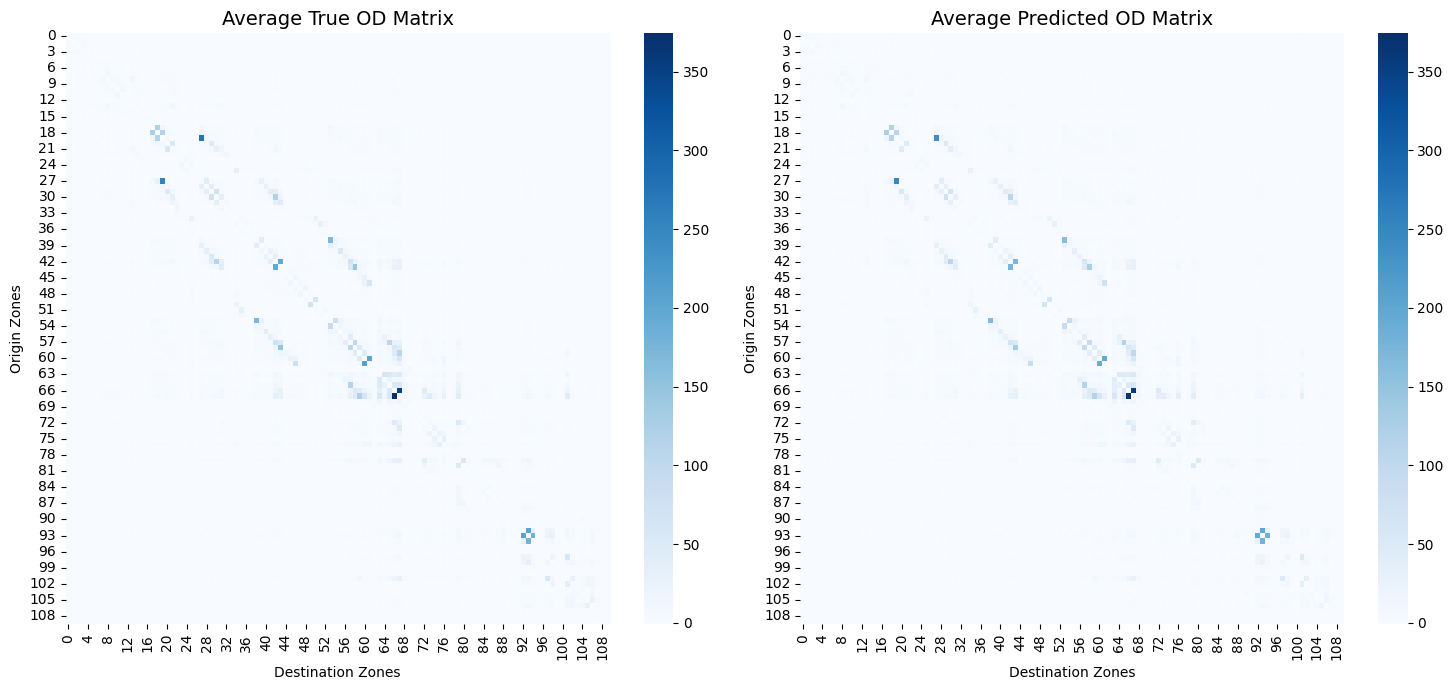

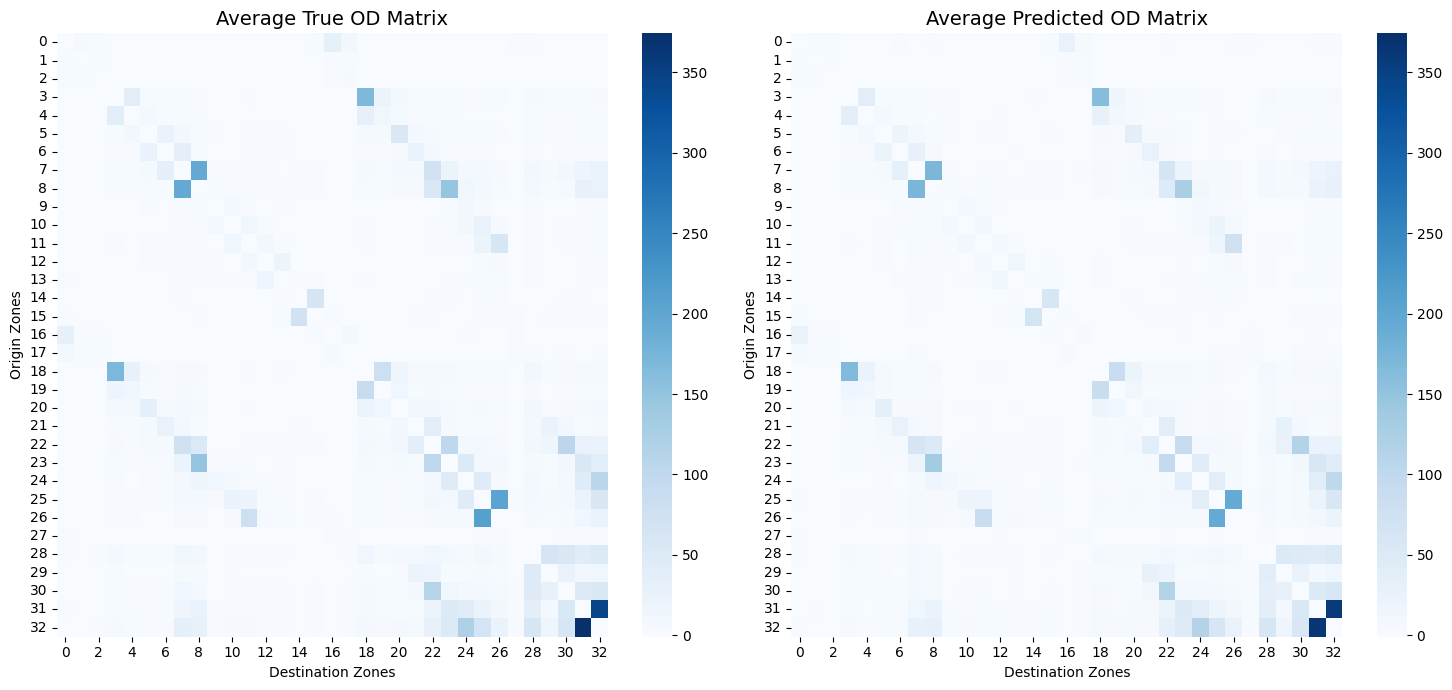

In [19]:
# 主程序
def main():
    train_loader, val_loader, test_loader = load_data()
    model = ODModel(N=110)  # N为区域数

    # # 定义不同的学习率
    # learning_rates = [0.5,0.4,0.2, 0.1, 0.05,0.01,0.005, 0.001, 0.0005,0.0001,0.00005,0.00001]

    lr = 0.0005

    # 训练模型
    # train_model(model, train_loader, val_loader, epochs=2000, patience=20, learning_rate=lr, load=1)

    # 测试模型
    test_model(model, test_loader)


if __name__ == "__main__":
    main()